In [1]:
import os 
import opendssdirect as dss
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az
import networkx as nx
import pandapower as pp

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV
import math
import pytensor

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Our data


1) From the metrics dataset, we have some useful properties for the 3-phase (for each feeder):
* Total Phase A Planning Load (MW)
* Total Phase B Planning Load (MW)
* Total Phase C Planning Load (MW)
* Number of Single Phase Low Voltage Loads
* Number of Three Phase Low Voltage Loads
* Percentage of Residential Customers
* Percentage of Commercial Customers
* Total Number of Customers


estimated_single_phase_a_active_power = total_phase_a/(num_three_phase_customers+num_single_phase*(1/3))


2) from the load_data dataset, we have
* total_site_electricity_kw
* total_site_electricity_kvar

3) from the profiles dataset we have the load timeseries in pu (between 0 and 1)


# Initial idea
1) gaussian mixture model:
* each feeder (f) will have a proportion of having a user from each phase (p_1,p_2,p_3)
* for each phase, the active power of each load will follow a normal distribution
* our goal is to learn from real data, sample from it and see the results

# Step 1: getting active power from data

In [2]:
power_df=pd.DataFrame(columns=['profile_id','p_kw','q_kvar'])


data_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\oedi_data'

data_subfolder=os.path.join(data_folder,'load_data')

for load_file in os.listdir(data_subfolder)[0:10]:
    file_name=os.path.join(data_subfolder,load_file)
    parquet_file=pd.read_parquet(file_name,engine='pyarrow')
    vehicle_id=load_file.split('_')[1].split('.')[0]
    for parque_idx in range(0,len(parquet_file.index),96): #get data from every 24 hours, just as an initial test case
        p_kw=parquet_file.at[parque_idx,'total_site_electricity_kw']
        q_kvar=parquet_file.at[parque_idx,'total_site_electricity_kvar']
        power_df.loc[len(power_df)]=[vehicle_id,p_kw,q_kvar]

<Axes: ylabel='Count'>

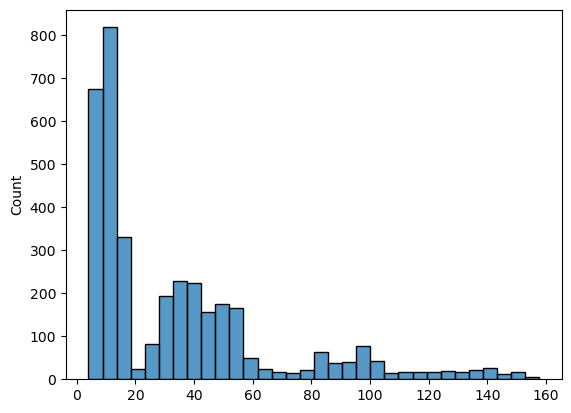

In [3]:
sns.histplot(list(power_df.p_kw))

# Step 2: getting important metrics from the metrics.csv file

In [4]:
data_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\oedi_data'
metrics=pd.read_csv(os.path.join(data_folder,'metrics.csv'))

num_single_loads=[]
num_three_phase_loads=[]
phases_proportion=[]
phases_planning=[]

for feeder_idx in metrics.index:
    num_single_loads.append(metrics.at[feeder_idx,'Number of Single Phase Low Voltage Loads'])
    num_three_phase_loads.append(metrics.at[feeder_idx,'Number of Three Phase Low Voltage Loads'])

    phase_a_proportion=metrics.at[feeder_idx,'Percentage of Low Voltage Peak Planning Load on Phase A']
    phase_b_proportion=metrics.at[feeder_idx,'Percentage of Low Voltage Peak Planning Load on Phase B']
    phase_c_proportion=metrics.at[feeder_idx,'Percentage of Low Voltage Peak Planning Load on Phase C']
    phases_proportion.append([phase_a_proportion/100,phase_b_proportion/100,phase_c_proportion/100])


    phase_a_planning=metrics.at[feeder_idx,'Total Phase A Peak Planning Load (MW)']
    phase_b_planning=metrics.at[feeder_idx,'Total Phase B Peak Planning Load (MW)']
    phase_c_planning=metrics.at[feeder_idx,'Total Phase C Peak Planning Load (MW)']
    phases_planning.append([phase_a_planning,phase_b_planning,phase_c_planning])




In [5]:
import numpy as np
ar=np.array(phases_proportion)
print(np.mean(ar[:,0]))
print(np.mean(ar[:,1]))
print(np.mean(ar[:,2]))

0.32493101041666667
0.32964221875
0.33501009375


# Step 3 - approach 1 - Gaussian Mixture Model for the active power

In [7]:
k=3
x=power_df.p_kw

c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\transforms.py:57: FutureWarning: univariate_ordered has been deprecated, use ordered instead.
  warnings.warn(f"{name} has been deprecated, use ordered instead.", FutureWarning)


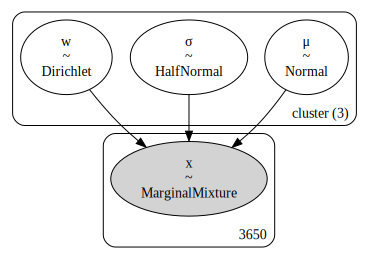

In [8]:
with pm.Model(coords={"cluster": range(k)}) as model:
    μ = pm.Normal(
        "μ",
        mu=0,
        sigma=5,
        transform=pm.distributions.transforms.univariate_ordered,
        initval=[10,50,100],
        dims="cluster",
    )
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster")
    weights = pm.Dirichlet("w", np.ones(k), dims="cluster")
    pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=x)

pm.model_to_graphviz(model)

In [9]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


[Text(0.5, 1.0, 'Group membership'),
 Text(0.5, 0, 'x'),
 Text(0, 0.5, 'Probability')]

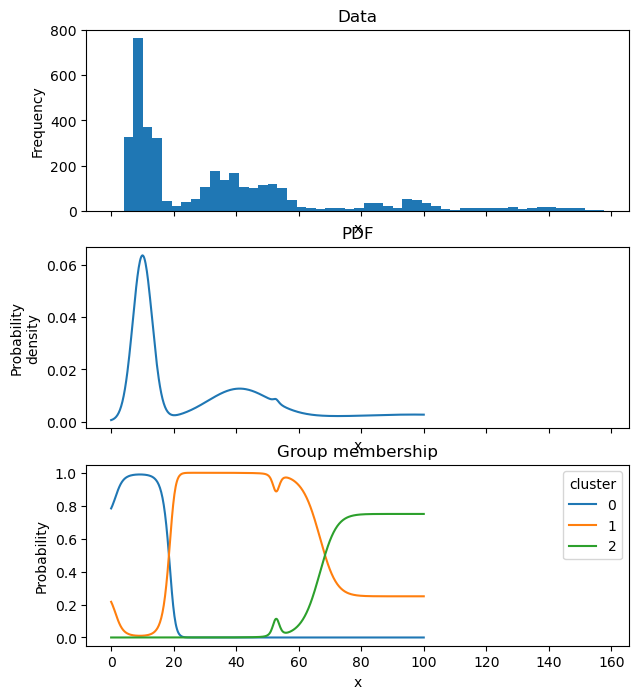

In [10]:
xi = np.linspace(0, 100, 500)
post = idata.posterior
pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["w"]
pdf = pdf_components.sum("cluster")

fig, ax = plt.subplots(3, 1, figsize=(7, 8), sharex=True)
# empirical histogram
ax[0].hist(x, 50)
ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
# pdf
pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
# plot group membership probabilities
(pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
ax[2].set(title="Group membership", xlabel="x", ylabel="Probability")

# Step 3 - approach 2 - bayesian hierarchical model
* each load may be 1-phase or 3-phase
* if it is one phase -> choose a phase following the active power proportional for each phase, and then sample the active power from the original active power data set
* if it is 3 phase -> go directly to the sampling phase of the active power dataset

## Using OpenDSS

In [4]:
import opendssdirect as dss
import os
import pandas as pd


In [5]:
def find_closest_transformer(coord_x,coord_y,transformer_distance_dict):
    closest_dist=1e9
    closest_transformer=None
    
    for transformer_key in transformer_distance_dict.keys():
        transformer_x=transformer_distance_dict[transformer_key][0]
        transformer_y=transformer_distance_dict[transformer_key][1]
        dist=np.sqrt((coord_x-transformer_x)**2+(coord_y-transformer_y)**2)
        if(dist<closest_dist):
            closest_dist=dist
            closest_transformer=transformer_key

    return [closest_transformer,closest_dist]


def distance_from_feeder(coord_x,coord_y):
    feeder_bus_name=list(dss.Circuit.AllBusNames())[0]
    #print(feeder_bus_name)
    dss.Circuit.SetActiveBus(feeder_bus_name)
    feeder_coord_x=dss.Bus.X()
    feeder_coord_y=dss.Bus.Y()

    dist=np.sqrt((coord_x-feeder_coord_x)**2+(coord_y-feeder_coord_y)**2)

    return dist


    

In [6]:
substation='p1uhs{}_1247'.format(i)
directory=os.path.join(opendss_folder,substation)

feeder_list = [f.name for f in os.scandir(directory) if f.is_dir() ]

for feeder in feeder_list:
    master_file = os.path.join(opendss_folder,substation,feeder,'Master.dss')

    dss.Text.Command('Redirect '+master_file)
    # Solve
    dss.Solution.Solve()

    feeder_bus_name=list(dss.Circuit.AllBusNames())[0]
    print(feeder_bus_name)
    dss.Circuit.SetActiveBus(feeder_bus_name)
    feeder_coord_x=dss.Bus.X()
    feeder_coord_y=dss.Bus.Y()

    distance = distance_from_feeder(feeder_coord_x,feeder_coord_y)
    print(distance)

p1udt12703-p1uhs0_1247x
0.0


DSSException: (#303) Error 303 Reported From OpenDSS Intrinsic Function: 
ProcessCommand: Exception Raised While Processing DSS Command: 
New Transformer.tr(r:p1udt326-p1udt326lv) phases=1 windings=3 %loadloss=0.798816 %Noloadloss=0.472 normhkva=27.5 wdg=1 con	n=wye bus=p1udt326.2 Kv=7.2 kva=25.0 EmergHKVA=37.5 %r=0.266272 wdg=2 conn=wye bus=p1udt326lv.1.0 Kv=0.12 kva=25.0 EmergHKVA=37.5 %r=0.532544 wdg=3 conn=wye bus=p1udt326lv.0.2 Kv=0.12 kva=25.0 EmergHKVA=37.5 %r=0.532544 XHL=2.4 XLT=2.4 XHT=1.6 

Error Description: 
Invalid inline math entry: "wye"

Probable Cause: 
Error in command string or circuit data.
[file: "C:\Users\hoc\Documents\Henrique\Doutorado\oedi_data\open_dss_2016_aus_p1u_base_scenario\p1uhs0_1247\p1uhs0_1247--p1udt2142\Transformers.dss", line: 7]
[file: "C:\Users\hoc\Documents\Henrique\Doutorado\oedi_data\open_dss_2016_aus_p1u_base_scenario\p1uhs0_1247\p1uhs0_1247--p1udt2142\Master.dss", line: 7]

# Part 2 - getting the number of phases for each load and for each line, trying to find a relationship with distance

In [7]:
phases_df_bus=pd.DataFrame(columns=['feeder','total_active_power','total_reactive_power','distance','phases'])

phases_df_line=pd.DataFrame(columns=['feeder','distance','phases','specific_phase'])
# all analysis is done for 2016 AUS P1U base scenario
opendss_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\oedi_data\open_dss_2016_aus_p1u_base_scenario'

def get_phases_from_nodes(nodes):
    """
    Translates a list of OpenDSS node numbers into a phase string (e.g., 'A', 'BC', 'ABC').
    Ignores neutral nodes (0).

    Args:
        nodes (list of int): The list of node numbers from dss.CktElement.NodeOrder().

    Returns:
        str: A string representing the phases, sorted alphabetically.
    """
    phase_map = {1: 'A', 2: 'B', 3: 'C'}
    
    # Filter out neutral nodes (0) and map the numbers to letters
    phase_letters = [phase_map.get(node) for node in nodes if node in phase_map]
    
    # Sort for consistency (e.g., 'AC' instead of 'CA') and join into a string
    return "".join(sorted(phase_letters))

# --- Example Usage ---


def get_phases_from_nodes(nodes):
    """
    Translates a list of OpenDSS node numbers into a phase string (e.g., 'A', 'BC', 'ABC').
    Ignores neutral nodes (0).

    Args:
        nodes (list of int): The list of node numbers from dss.CktElement.NodeOrder().

    Returns:
        str: A string representing the phases, sorted alphabetically.
    """
    phase_map = {1: 'A', 2: 'B', 3: 'C'}
    
    # Get the unique set of phase conductors from the node list
    # This handles the fact that lines have two terminals
    unique_phase_nodes = sorted(list(set(node for node in nodes if node in phase_map)))
    
    # Map the unique node numbers to letters and join into a string
    return "".join([phase_map.get(node) for node in unique_phase_nodes])



for i in range(1):
    print(i)
    substation='p1uhs{}_1247'.format(i)
    directory=os.path.join(opendss_folder,substation)

    feeder_list = [f.name for f in os.scandir(directory) if f.is_dir() ]

    for feeder in feeder_list:
        master_file = os.path.join(opendss_folder,substation,feeder,'Master.dss')

        dss.Text.Command('Redirect '+master_file)
        # Solve
        dss.Solution.Solve()

        #feeder_bus_name=list(dss.Circuit.AllBusNames())[0]
        #feeder_coord_x=dss.Bus.X()
        #feeder_coord_y=dss.Bus.Y()
        #print(feeder_bus_name,feeder_coord_x,feeder_coord_y)

        for line in dss.Lines:
            bus_1=line.Bus1()
            dss.Circuit.SetActiveBus(bus_1)
            coord_x=dss.Bus.X()
            coord_y=dss.Bus.Y()
            distance=distance_from_feeder(coord_x,coord_y)
            #print(dss.Bus.LoadList())
            for load_name in dss.Bus.LoadList():
                if(load_name!=''):
                    print('oi')
                    dss.Loads.Name(load_name.split('.')[1])
                    active_power=dss.Loads.kW()
                    reactive_power=dss.Loads.kvar()
                    phases_load=dss.Loads.Phases()
                    phases_df_bus.loc[len(phases_df_bus)]=[feeder,active_power,reactive_power,distance,phases_load]

            bus_2=line.Bus2()
            dss.Circuit.SetActiveBus(bus_2)
            coord_x=dss.Bus.X()
            coord_y=dss.Bus.Y()
            distance=distance_from_feeder(coord_x,coord_y)
            for load_name in dss.Bus.LoadList():
                if(load_name!=''):
                    print('oi')
                    dss.Loads.Name(load_name.split('.')[1])
                    active_power=dss.Loads.kW()
                    reactive_power=dss.Loads.kvar()
                    phases_load = dss.Loads.Phases()

                    # 2. Get the specific node connections for the active element
                    node_list = dss.CktElement.NodeOrder()

                    # 3. Translate the node list into a human-readable phase string
                    specific_phases = get_phases_from_nodes(node_list)
                    phases_df_bus.loc[len(phases_df_bus)]=[feeder,active_power,reactive_power,distance,phases_load]


            phases_line=line.Phases()

            # 2. Set the current line as the active element
            # The high-level line object gives us the name directly
            full_line_name = f"Line.{line.Name()}"
            dss.Circuit.SetActiveElement(full_line_name)
            
            # 3. Get the specific node connections for the active element
            node_list = dss.CktElement.NodeOrder()
            
            # 4. Translate the node list into a human-readable phase string
            specific_phases = get_phases_from_nodes(node_list)
            print(node_list)

            phases_df_line.loc[len(phases_df_line)]=[feeder,distance,phases_line,specific_phases]

0
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 2]
[1, 2, 1, 

KeyboardInterrupt: 

In [91]:

phases_df_line['normalized_distance'] = phases_df_line['distance'] / phases_df_line.groupby('feeder')['distance'].transform('max')

In [93]:
phases_df_line[phases_df_line.phases==2].normalized_distance.mean()

0.3378418191816913

In [95]:
phases_df_line[phases_df_line.phases==1].normalized_distance.mean()

0.3505049079321553

In [96]:
phases_df_line.to_csv('phase_allocation_vs_distance_smart_ds.csv')

# Testing with the 123 bus dss system

In [26]:
dss.Text.Command('Redirect '+master_file)
# Solve
dss.Solution.Solve()

In [59]:
phases_df_bus=pd.DataFrame(columns=['total_active_power','total_reactive_power','distance','phases'])

phases_df_line=pd.DataFrame(columns=['distance','phases'])
opendss_folder='ieee123'

master_file = os.path.join(opendss_folder,'IEEE123Master.dss')

dss.Text.Command('Redirect '+master_file)
# Solve
dss.Solution.Solve()

#feeder_bus_name=list(dss.Circuit.AllBusNames())[0]
#feeder_coord_x=dss.Bus.X()
#feeder_coord_y=dss.Bus.Y()
#print(feeder_bus_name,feeder_coord_x,feeder_coord_y)

for line in dss.Lines:
    bus_1=line.Bus1()
    dss.Circuit.SetActiveBus(bus_1)
    coord_x=dss.Bus.X()
    coord_y=dss.Bus.Y()
    distance=distance_from_feeder(coord_x,coord_y)
    #print(dss.Bus.LoadList())
    for load_name in dss.Bus.LoadList():
        if(load_name!=''):
            print('oi')
            dss.Loads.Name(load_name.split('.')[1])
            active_power=dss.Loads.kW()
            reactive_power=dss.Loads.kvar()
            phases_load=dss.Loads.Phases()
            phases_df_bus.loc[len(phases_df_bus)]=[active_power,reactive_power,distance,phases_load]

    bus_2=line.Bus2()
    dss.Circuit.SetActiveBus(bus_2)
    coord_x=dss.Bus.X()
    coord_y=dss.Bus.Y()
    distance=distance_from_feeder(coord_x,coord_y)
    for load_name in dss.Bus.LoadList():
        if(load_name!=''):
            print('oi')
            dss.Loads.Name(load_name.split('.')[1])
            active_power=dss.Loads.kW()
            reactive_power=dss.Loads.kvar()
            phases_load=dss.Loads.Phases()
            phases_df_bus.loc[len(phases_df_bus)]=[active_power,reactive_power,distance,phases_load]

    print(coord_x)
    phases_line=line.Phases()
    phases_df_line.loc[len(phases_df_line)]=[distance,phases_line]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [12]:
phases_df_line.distance

0       0.001723
1       0.001412
2       0.001636
3       0.001520
4       0.003582
          ...   
6698    0.007433
6699    0.007155
6700    0.004512
6701    0.004622
6702    0.011674
Name: distance, Length: 6703, dtype: float64

# Generating the phases probability for each distance

* prob_3_phase[d][k] = p means that for a bus with distance d from the feeder, there is probability p that the bus will be k-phase 

In [16]:
prob_3_phases={}

max_distance=0.04

distance_step_list=np.linspace(0,max_distance,20)

prob_3_phases[1]={}
prob_3_phases[2]={}
prob_3_phases[3]={}

for distance_idx in range(1,len(distance_step_list)):
    low_distance=distance_step_list[distance_idx-1]
    high_distance=distance_step_list[distance_idx]

    
    
    threshold_list=phases_df_line[(phases_df_line.distance>low_distance) & (phases_df_line.distance<high_distance)].phases
    
    prob_3_phases[1][low_distance/max_distance]=sum(threshold_list==1)/len(threshold_list)
    prob_3_phases[2][low_distance/max_distance]=sum(threshold_list==2)/len(threshold_list)
    prob_3_phases[3][low_distance/max_distance]=sum(threshold_list==3)/len(threshold_list)




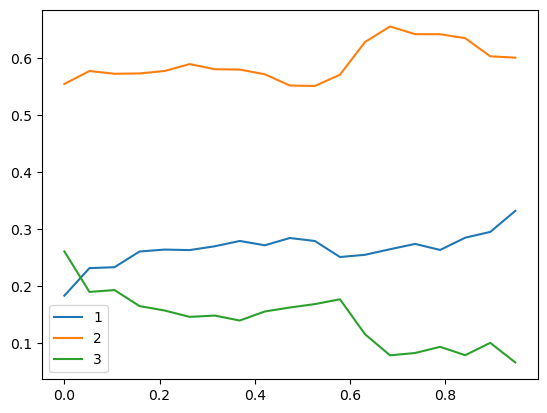

In [17]:
plt.plot(prob_3_phases[1].keys(),prob_3_phases[1].values(),label='1')
plt.plot(prob_3_phases[2].keys(),prob_3_phases[2].values(),label='2')
plt.plot(prob_3_phases[3].keys(),prob_3_phases[3].values(),label='3')
plt.legend()
plt.show()

# Saving all generated data

In [28]:
import pickle

to_save_folder=r'C:\Users\hoc\Documents\Henrique\Doutorado\codigos_linux\dev\phd\papers\artigo_3_phase_synthetic\generated_data'

pickle.dump(prob_3_phases,open(os.path.join(to_save_folder,'prob_3_phases.pickle'),'wb'))

pickle.dump(phases_proportion,open(os.path.join(to_save_folder,'phases_proportion.pickle'),'wb'))

pickle.dump(phases_planning,open(os.path.join(to_save_folder,'phases_planning.pickle'),'wb'))

pickle.dump(power_df,open(os.path.join(to_save_folder,'power_df.pickle'),'wb'))


# Next step: using the full model to generate unbalanced, 3-phase system

* Important: in pandapower, the bus geographic position is stored in bus_geodata. But the code can be adapted for opendss or other data.

In [14]:
net=pp.networks.case145()
graph_from_net=pp.topology.create_nxgraph(net,include_trafos=False,multi=False)

# defining x and y coordinates for each bus

x_dict={}
y_dict={}

for bus_idx in net.bus.index:
    x_dict[bus_idx]=net.bus_geodata.at[bus_idx,'x']
    y_dict[bus_idx]=net.bus_geodata.at[bus_idx,'y']

nx.set_node_attributes(graph_from_net,x_dict,'x')
nx.set_node_attributes(graph_from_net,y_dict,'y')


# defining the x and y for the gen
bus_gen=net.gen.at[0,'bus']
x_gen=net.bus_geodata.at[bus_gen,'x']
y_gen=net.bus_geodata.at[bus_gen,'y']


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pandapower\io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
c:\Users\hoc\anacon

# Now we must define:

* for each bus: phase, active power, reactive power
* for each line: phase

In [ ]:
#calculating max distance (from a given node to feeder)

max_distance=0
for node in graph_from_net.nodes:
    x=graph_from_net.nodes[node]['x']
    y=graph_from_net.nodes[node]['y']
    distance=np.sqrt((x-x_gen)**2+(y-y_gen)**2)
    if(distance>max_distance):
        max_distance=distance

print(max_distance)

9.41006176730768


### Defining number of phases for each line 

* based on the probability (given by data) and the distance from node to feeder

In [17]:
phases_line_list=[]
prop_three_phase_dict={}

for u,v in graph_from_net.edges():
    x_line=graph_from_net.nodes[v]['x']
    y_line=graph_from_net.nodes[v]['y']
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    #print(normalized_dist)

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])

    random_number=np.random.rand() #random for line
    if(random_number<=individual_prob_list[0]):
        phases_line_list.append(1)
    elif(random_number<=individual_prob_list[1]):
        phases_line_list.append(2)
    else:
        phases_line_list.append(3)

for u in graph_from_net.nodes:
    x_line=graph_from_net.nodes[u]['x']
    y_line=graph_from_net.nodes[u]['y']
    distance_from_feeder=np.sqrt((x_line-x_gen)**2+(y_line-y_gen)**2)
    normalized_dist=distance_from_feeder/max_distance
    #print(normalized_dist)

    rounded_dist=0
    for distance_key in prob_3_phases[1].keys():
        if(distance_key>normalized_dist):
            rounded_dist=distance_key
            break

    #individual_prob_list=np.cumsum([prob_3_phases[1][rounded_dist],prob_3_phases[2][rounded_dist],prob_3_phases[3][rounded_dist]])


    prop_three_phase_dict[u]=prob_3_phases[3][rounded_dist]


# Probability of being 3-phase for each node in the graph

In [93]:
prop_three_phase_dict

{0: 0.17066666666666666,
 1: 0.17066666666666666,
 5: 0.16225165562913907,
 6: 0.16225165562913907,
 8: 0.1895910780669145,
 9: 0.1895910780669145,
 11: 0.16259298618490967,
 7: 0.20583090379008748,
 65: 0.16943521594684385,
 10: 0.1895910780669145,
 68: 0.18255120141912595,
 13: 0.16259298618490967,
 24: 0.18255120141912595,
 12: 0.18255120141912595,
 71: 0.15229013148388962,
 16: 0.18255120141912595,
 14: 0.16259298618490967,
 57: 0.18255120141912595,
 15: 0.1895910780669145,
 21: 0.16259298618490967,
 17: 0.1638971488542942,
 58: 0.19729965156794424,
 18: 0.15229013148388962,
 19: 0.15229013148388962,
 20: 0.1638971488542942,
 23: 0.16943521594684385,
 22: 0.16259298618490967,
 82: 0.18255120141912595,
 26: 0.1895910780669145,
 25: 0.19729965156794424,
 72: 0.15229013148388962,
 27: 0.16225165562913907,
 74: 0.18255120141912595,
 28: 0.16225165562913907,
 29: 0.1895910780669145,
 77: 0.16943521594684385,
 30: 0.1638971488542942,
 73: 0.15229013148388962,
 31: 0.1895910780669145,
 32

# Phases for each line 

In [19]:
phases_line_list

[1,
 1,
 2,
 2,
 1,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 3,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 3,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 1,
 2,
 2,
 2,
 3,
 1,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 1,
 2,
 3,
 2,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 1,
 3,
 3,
 2,
 3,
 2,
 3,
 1,
 3,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 3,
 2,
 3,
 1,
 3,
 1,
 2,
 1,
 2,
 1,
 3,
 3,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 1,
 2,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 1,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 3,
 2,
 3,
 1,
 2,
 3,
 1,
 3,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 1,
 3,
 1,
 2,
 1,
 3,
 3,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 3,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 3,
 3,
 1,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,


<Axes: ylabel='Count'>

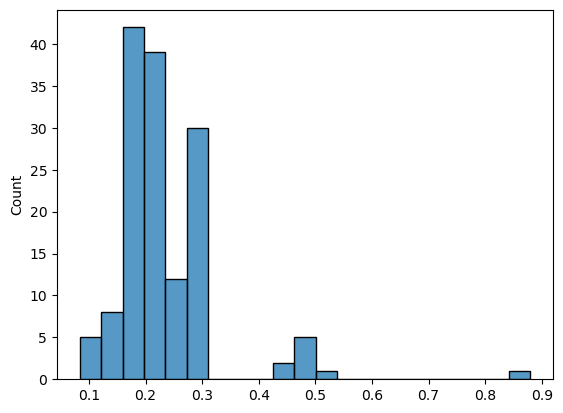

In [20]:
sns.histplot(list(prop_three_phase_dict.values()))

In [192]:
mu_p_a

2.3479903838229164

In [274]:
#num_single_loads
#num_three_phase_loads
#phases_planning
#phases_proportion

with pm.Model() as three_phase_model:
    feeder_idx=0


    # proportion of each phase
    num_total_loads=len(graph_from_net.nodes)
    #num_total_loads=5
    #num_total_loads=int(num_single_loads[feeder_idx]+num_three_phase_loads[feeder_idx])
    #prop_three_phase=num_three_phase_loads[feeder_idx]/num_total_loads
    prob_three_phase=np.mean(list(prop_three_phase_dict.values())) # for expected we use the mean value
    #prob_three_phase=0

    three_phase_choice=pm.Bernoulli('three_phase_choice',p=prob_three_phase,shape=num_total_loads)



    mu_prop_a=np.mean([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
    #var_prop_a=np.std([phases_proportion[idx][0] for idx in range(len(phases_proportion))])
    #prop_a=pm.TruncatedNormal('prop_a',mu=mu_prop_a,sigma=var_prop_a,shape=num_total_loads,lower=0)

    mu_prop_b=np.mean([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
    #var_prop_b=np.std([phases_proportion[idx][1] for idx in range(len(phases_proportion))])
    #prop_b=pm.TruncatedNormal('prop_b',mu=mu_prop_b,sigma=var_prop_b,shape=num_total_loads,lower=0)

    mu_prop_c=np.mean([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
    #var_prop_c=np.std([phases_proportion[idx][2] for idx in range(len(phases_proportion))])
    #prop_c=pm.TruncatedNormal('prop_c',mu=mu_prop_c,sigma=var_prop_c,shape=num_total_loads,lower=0)

    # phase choice



    phase_choice=pm.Categorical('phase_choice',p=[mu_prop_a,mu_prop_b,mu_prop_c],shape=num_total_loads)


    # defining load of each phase
    mu_p_a=np.mean([phases_planning[idx][0] for idx in range(len(phases_planning))])
    var_p_a=np.std([phases_planning[idx][0] for idx in range(len(phases_planning))])
    #expected_p_a=pm.Deterministic('mu_p_a',mu_p_a/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_a))) #phase a
    p_a=pm.TruncatedNormal('P_a',mu=mu_p_a,lower=0,sigma=var_p_a,shape=(num_total_loads))

    mu_p_b=np.mean([phases_planning[idx][1] for idx in range(len(phases_planning))])
    var_p_b=np.std([phases_planning[idx][1] for idx in range(len(phases_planning))])
    #expected_p_b=pm.Deterministic('mu_p_b',mu_p_b/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_b))) #phase b
    p_b=pm.TruncatedNormal('P_b',mu=mu_p_b,lower=0,sigma=var_p_b,shape=(num_total_loads))

    mu_p_c=np.mean([phases_planning[idx][2] for idx in range(len(phases_planning))])
    var_p_c=np.std([phases_planning[idx][2] for idx in range(len(phases_planning))])
    #expected_p_c=pm.Deterministic('mu_p_c',mu_p_c/(num_total_loads*(prop_three_phase*1/3+(1-prop_three_phase)*prop_c))) #phase c
    p_c=pm.TruncatedNormal('P_c',mu=mu_p_c,lower=0,sigma=var_p_c,shape=(num_total_loads))


    real_p_a=pm.Deterministic('real_p_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),p_a,0),p_a/3))
    real_p_b=pm.Deterministic('real_p_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),p_b,0),p_b/3))
    real_p_c=pm.Deterministic('real_p_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),p_c,0),p_c/3))



    power_factor_mu=np.mean(power_df.p_kw/(power_df.q_kvar+power_df.p_kw)) #calculating power factor for each node
    power_factor=pm.Beta('power_factor',mu=power_factor_mu,sigma=power_factor_mu*0.1,shape=num_total_loads)

    q_a=pm.TruncatedNormal('Q_a',mu=mu_p_a*power_factor,lower=0,shape=(num_total_loads))
    q_b=pm.TruncatedNormal('Q_b',mu=mu_p_b*power_factor,lower=0,shape=(num_total_loads))
    q_c=pm.TruncatedNormal('Q_c',mu=mu_p_c*power_factor,lower=0,shape=(num_total_loads))

    real_q_a=pm.Deterministic('real_q_a',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 0),q_a,0),q_a/3))
    real_q_b=pm.Deterministic('real_q_b',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 1),q_b,0),q_b/3))
    real_q_c=pm.Deterministic('real_q_c',pm.math.switch(pytensor.tensor.eq(three_phase_choice, 0),pm.math.switch(pytensor.tensor.eq(phase_choice, 2),q_c,0),q_c/3))

    #phases_planning[feeder_idx]
    #active_power_load=pm.Normal(mu=)


c:\Users\hoc\anaconda3\envs\lps\Lib\site-packages\pymc\distributions\discrete.py:1130: UserWarning: `p` parameters sum to [0.98958332], instead of 1.0. They will be automatically rescaled. You can rescale them directly to get rid of this warning.
  warnings.warn(


prop_p_a,b,c~MultiBeta()
prop_p_a->P_a
sum_p->P_a
P_a=prop_p_a*sum_p

In [26]:
pm.model_to_graphviz(three_phase_model)

NameError: name 'three_phase_model' is not defined

In [262]:
with three_phase_model:
    idata = pm.sample(draws=1000,chains=4,tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [three_phase_choice]
>CategoricalGibbsMetropolis: [phase_choice]
>NUTS: [P_a, P_b, P_c, power_factor, Q_a, Q_b, Q_c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 158 seconds.


In [263]:
i=0
print('sample ',i)
print('phase A',[round(i,2) for i in list(idata.posterior['real_p_a'][0][i].values)])
print('phase B',[round(i,2) for i in list(idata.posterior['real_p_b'][0][i].values)])
print('phase C',[round(i,2) for i in list(idata.posterior['real_p_c'][0][i].values)])

print('------------')
i=3
print('sample ',i)
print('phase A',[round(i,2) for i in list(idata.posterior['real_p_a'][0][i].values)])
print('phase B',[round(i,2) for i in list(idata.posterior['real_p_b'][0][i].values)])
print('phase C',[round(i,2) for i in list(idata.posterior['real_p_c'][0][i].values)])


sample  0
phase A [0.0, 0.0, 3.1, 0.0, 0.0, 2.23, 0.0, 0.0, 0.0, 2.27, 0.0, 3.82, 0.0, 0.0, 2.78, 0.0, 0.16, 1.11, 3.78, 0.75, 0.35, 0.0, 0.57, 1.5, 0.95, 0.0, 0.0, 2.05, 2.94, 1.39, 3.12, 0.0, 0.0, 0.0, 6.27, 0.0, 1.3, 0.0, 0.0, 0.0, 0.0, 0.63, 0.47, 0.0, 0.55, 0.0, 1.38, 0.0, 4.98, 0.0, 1.17, 0.0, 0.0, 2.17, 0.0, 0.0, 0.0, 0.0, 0.0, 3.15, 0.0, 0.86, 0.83, 1.75, 1.55, 0.74, 0.0, 1.15, 0.0, 0.0, 0.92, 0.0, 0.0, 0.55, 0.0, 0.0, 1.52, 0.0, 0.0, 0.0, 1.78, 4.7, 0.0, 1.94, 0.62, 0.0, 0.0, 0.0, 0.0, 2.52, 2.12, 3.74, 0.25, 0.0, 1.99, 1.71, 0.0, 0.0, 0.38, 0.0, 0.0, 3.38, 0.0, 0.94, 0.2, 0.0, 0.0, 1.07, 1.59, 0.0, 4.06, 0.0, 0.0, 0.0, 0.0, 1.55, 2.34, 0.0, 0.0, 0.0, 0.0, 2.73, 0.0, 0.57, 0.08, 0.96, 1.13, 2.83, 0.94, 3.35, 1.86, 1.48, 1.67, 3.26, 1.87, 0.0, 4.01, 0.0, 0.7, 2.53, 0.86, 0.09, 0.0, 0.0, 1.1]
phase B [3.13, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.74, 0.0, 3.72, 0.0, 0.0, 1.8, 0.0, 0.0, 0.89, 0.05, 0.0, 0.47, 0.08, 0.0, 0.0, 0.0, 0.8, 3.86, 5.77, 0.0, 0.0, 0.55, 0.0, 3.36, 0.0, 0.0

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

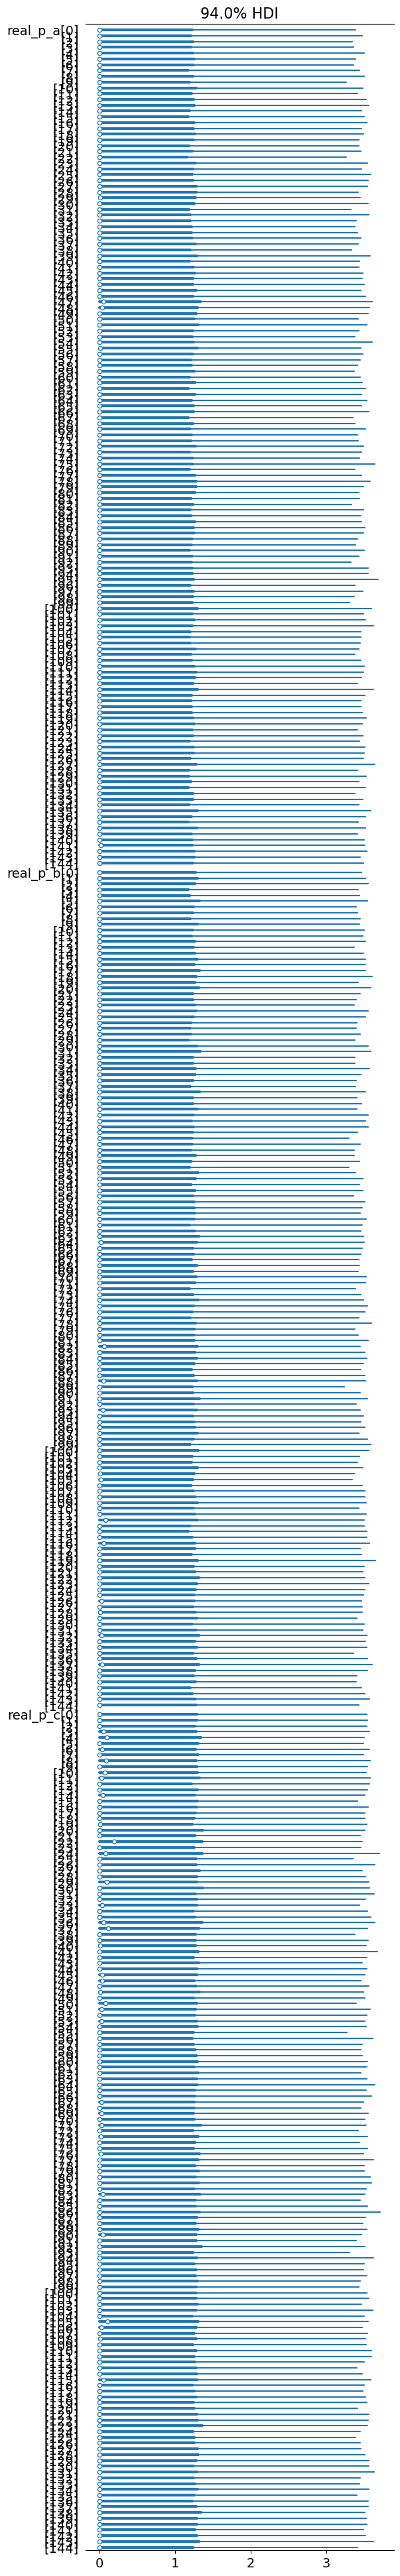

In [264]:
az.plot_forest(idata,var_names=['real_p_a','real_p_b','real_p_c'],combined=True)

# Summarizing all the information 



In [265]:
# probability of each node being three phase 
prop_three_phase_dict

{0: 0.08346972176759411,
 1: 0.08346972176759411,
 5: 0.20915032679738563,
 6: 0.20915032679738563,
 8: 0.21061359867330018,
 9: 0.21061359867330018,
 11: 0.19021739130434784,
 7: 0.18387096774193548,
 65: 0.2868686868686869,
 10: 0.21061359867330018,
 68: 0.26382978723404255,
 13: 0.19021739130434784,
 24: 0.26382978723404255,
 12: 0.26382978723404255,
 71: 0.18457300275482094,
 16: 0.26382978723404255,
 14: 0.19021739130434784,
 57: 0.26382978723404255,
 15: 0.21061359867330018,
 21: 0.19021739130434784,
 17: 0.2222222222222222,
 58: 0.2890625,
 18: 0.18457300275482094,
 19: 0.18457300275482094,
 20: 0.2222222222222222,
 23: 0.2868686868686869,
 22: 0.19021739130434784,
 82: 0.26382978723404255,
 26: 0.21061359867330018,
 25: 0.2890625,
 72: 0.18457300275482094,
 27: 0.20915032679738563,
 74: 0.26382978723404255,
 28: 0.20915032679738563,
 29: 0.21061359867330018,
 77: 0.2868686868686869,
 30: 0.2222222222222222,
 73: 0.18457300275482094,
 31: 0.21061359867330018,
 32: 0.154237288135

In [266]:
# phases for each line 
phases_line_list

[1,
 1,
 2,
 2,
 1,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 1,
 3,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 3,
 2,
 2,
 2,
 3,
 3,
 2,
 2,
 1,
 2,
 2,
 2,
 3,
 1,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 1,
 2,
 3,
 2,
 1,
 3,
 2,
 1,
 3,
 3,
 2,
 1,
 3,
 3,
 2,
 3,
 2,
 3,
 1,
 3,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 3,
 2,
 3,
 1,
 3,
 1,
 2,
 1,
 2,
 1,
 3,
 3,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 1,
 2,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 1,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 3,
 2,
 3,
 1,
 2,
 3,
 1,
 3,
 1,
 1,
 3,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 1,
 3,
 1,
 2,
 1,
 3,
 3,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 3,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 3,
 3,
 1,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,


In [256]:
# final active power for phase p of node n
phase='a' # a, b or c
node=0
chain=3 # chain in {0,1,2,3}
sample=500 # sample from 0 to 99

print('node {}, phase {}'.format(phase,node),idata.posterior['real_p_{}'.format(phase)][chain][sample][node].item())


# or 
print('node {}, all phases'.format(node))
phase_a=idata.posterior['real_p_a'][chain][sample][node].item()
phase_b=idata.posterior['real_p_b'][chain][sample][node].item()
phase_c=idata.posterior['real_p_c'][chain][sample][node].item()
print('phase a',phase_a)
print('phase b',phase_b)
print('phase c',phase_c)


node a, phase 0 0.0
node 0, all phases
phase a 0.0
phase b 2.8614841322378717
phase c 0.0


# Generating a dataframe containing all samples

* we have 4 chains and 1000 samples, so 40000 samples in total
* can be saved to a pickle format
* will save just 12 samples for now

In [277]:
[num_chains,num_samples,num_loads]=idata.posterior['P_a'].shape

sample_idx=0

df_dict={}

load_list_a=[[] for k_idx in range(num_loads)]
load_list_b=[[] for k_idx in range(num_loads)]
load_list_c=[[] for k_idx in range(num_loads)]

for i in range(4): #chains
    for j in range(3): #samples
        df_dict[sample_idx]=pd.DataFrame(columns=['node','p_a','q_a','p_b','q_b','p_c','q_c'])
        for k in range(num_loads):
            phase_a_p=float(idata.posterior['real_p_a'][i][j][k].values)
            phase_a_q=float(idata.posterior['real_q_a'][i][j][k].values)
            phase_b_p=float(idata.posterior['real_p_b'][i][j][k].values)
            phase_b_q=float(idata.posterior['real_q_b'][i][j][k].values)
            phase_c_p=float(idata.posterior['real_p_c'][i][j][k].values)
            phase_c_q=float(idata.posterior['real_q_c'][i][j][k].values)
            df_dict[sample_idx].loc[len(df_dict[sample_idx])]=[k,phase_a_p,phase_a_q,phase_b_p,phase_b_q,phase_c_p,phase_c_q]
    
        sample_idx+=1

In [278]:
df_dict[0]

,node,p_a,q_a,p_b,q_b,p_c,q_c
0,0.0,0.000000,0.000000,3.127003,3.526317,0.000000,0.000000
1,1.0,0.000000,0.000000,0.456568,1.853490,0.000000,0.000000
2,2.0,3.098570,0.691042,0.000000,0.000000,0.000000,0.000000
3,3.0,0.000000,0.000000,0.000000,0.000000,0.516737,1.109921
4,4.0,0.000000,0.000000,0.000000,0.000000,1.421745,1.122984
5,5.0,2.231298,2.227846,0.000000,0.000000,0.000000,0.000000
6,6.0,0.000000,0.000000,0.000000,0.000000,1.728558,0.949558
7,7.0,0.000000,0.000000,0.000000,0.000000,3.774771,1.299964
8,8.0,0.000000,0.000000,3.735279,2.196781,0.000000,0.000000
9,9.0,2.273305,0.643460,0.000000,0.000000,0.000000,0.000000
